In [ ]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-727i9ae1/pafy_722f17cdb90c4394955ae0987c03fff5
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-727i9ae1/pafy_722f17cdb90c4394955ae0987c03fff5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

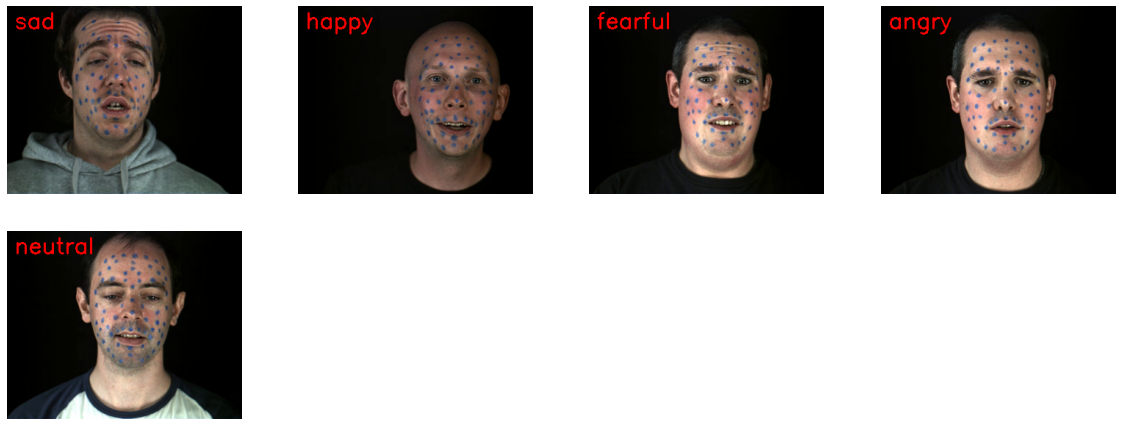

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/content/drive/MyDrive/SAVEEvideowithlabel')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)),5)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/SAVEEvideowithlabel/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/SAVEEvideowithlabel/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
 # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset. 
#DATASET_DIR = "/content/drive/MyDrive/videospeechsong_label"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["neutral", "happy", "sad","angry","fearful"]

In [ ]:
import joblib
features = joblib.load('/content/drive/My Drive/SAVEEfeatures/features_data')
labels = joblib.load('/content/drive/MyDrive/SAVEEfeatures/labels')
video_files_paths = joblib.load('/content/drive/My Drive/SAVEEfeatures/video_path')

In [ ]:
features = np.asarray(features)
labels = np.array(labels)

In [ ]:
features.shape

(360, 30, 64, 64, 3)

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:

# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.10, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
   
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (5, 5), padding='same'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.1)))
    
    model.add(TimeDistributed(Conv2D(32, (5, 5), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(64, (5, 5), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, (5, 5), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(64))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 16)   1216      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 64, 64, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 16, 16, 16)   0

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 25, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.1, callbacks = [early_stopping_callback])

Epoch 1/100
73/73 [==============================] - 6s 29ms/step - loss: 1.5879 - accuracy: 0.3162 - val_loss: 1.6338 - val_accuracy: 0.2727
Epoch 2/100
73/73 [==============================] - 1s 16ms/step - loss: 1.5809 - accuracy: 0.3402 - val_loss: 1.6084 - val_accuracy: 0.3333
Epoch 3/100
73/73 [==============================] - 1s 16ms/step - loss: 1.5039 - accuracy: 0.4055 - val_loss: 1.6429 - val_accuracy: 0.2727
Epoch 4/100
73/73 [==============================] - 1s 16ms/step - loss: 1.4607 - accuracy: 0.3849 - val_loss: 1.6226 - val_accuracy: 0.3030
Epoch 5/100
73/73 [==============================] - 1s 16ms/step - loss: 1.4937 - accuracy: 0.3436 - val_loss: 1.6016 - val_accuracy: 0.2727
Epoch 6/100
73/73 [==============================] - 1s 16ms/step - loss: 1.4453 - accuracy: 0.3677 - val_loss: 1.6829 - val_accuracy: 0.2727
Epoch 7/100
73/73 [==============================] - 1s 16ms/step - loss: 1.3496 - accuracy: 0.4124 - val_loss: 1.5502 - val_accuracy: 0.3030
Epoch 

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

2/2 [==============================] - 0s 12ms/step - loss: 0.2058 - accuracy: 0.9444


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

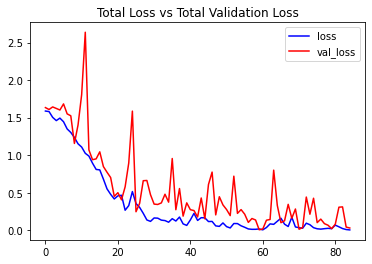

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

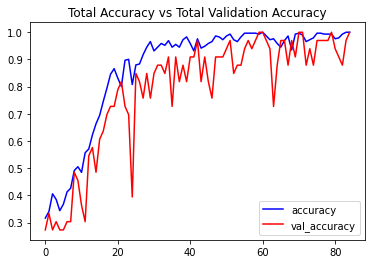

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
predictions =  LRCN_model.predict(features_test)
predictions

array([[1.90027669e-04, 1.44521937e-05, 9.98018742e-01, 3.50672606e-04,
        1.42607652e-03],
       [2.35023699e-03, 2.58235671e-02, 5.18099288e-04, 9.69483018e-01,
        1.82508584e-03],
       [1.56980805e-05, 9.97315705e-01, 6.82260434e-05, 2.89075339e-04,
        2.31136917e-03],
       [5.02085313e-05, 6.91206020e-04, 2.92884023e-03, 3.10460018e-05,
        9.96298730e-01],
       [3.56333883e-04, 4.18284744e-01, 7.40638352e-04, 5.80358207e-01,
        2.60137545e-04],
       [4.92229650e-04, 9.51497786e-05, 9.59127963e-01, 1.06191088e-03,
        3.92226949e-02],
       [3.86565947e-03, 2.52571608e-05, 9.91159737e-01, 2.64697429e-03,
        2.30245036e-03],
       [4.34970018e-04, 1.33058284e-05, 9.96277988e-01, 9.12533957e-04,
        2.36134254e-03],
       [6.68290188e-04, 1.27581495e-03, 5.33142127e-04, 9.97436702e-01,
        8.61303270e-05],
       [4.64793775e-05, 6.33933290e-04, 2.60890694e-03, 2.81515113e-05,
        9.96682465e-01],
       [9.97925997e-01, 1.0565

In [ ]:
preds=predictions.argmax(axis=1)
preds

array([2, 3, 1, 4, 3, 2, 2, 2, 3, 4, 0, 0, 4, 1, 4, 1, 0, 0, 3, 0, 0, 2,
       3, 0, 0, 0, 1, 3, 3, 0, 0, 3, 2, 1, 3, 2])

In [ ]:
new_preds = preds.astype(int).flatten()
new_preds

array([2, 3, 1, 4, 3, 2, 2, 2, 3, 4, 0, 0, 4, 1, 4, 1, 0, 0, 3, 0, 0, 2,
       3, 0, 0, 0, 1, 3, 3, 0, 0, 3, 2, 1, 3, 2])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.80      1.00      0.89         4
           2       0.86      1.00      0.92         6
           3       1.00      0.90      0.95        10
           4       1.00      0.80      0.89         5

    accuracy                           0.94        36
   macro avg       0.93      0.94      0.93        36
weighted avg       0.95      0.94      0.94        36

----accuracy score 94.44444444444444 ----


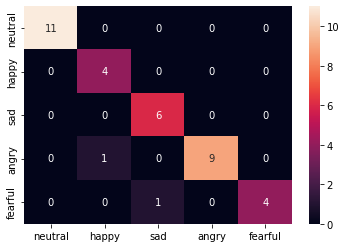

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
new_labels=np.argmax(labels_test, axis=1)
print(classification_report(new_labels,new_preds))

acc = float(accuracy_score(new_labels,new_preds))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(new_labels,new_preds)
#df_cm = pd.DataFrame(cm)
class_names = ['neutral', 'happy','sad','angry', 'fearful' ]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names,)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()